# Predict media from taxa

In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import plotly.express as px
from sklearn.cluster import KMeans
import umap

import os
DATA_DIR = "~/Desktop/code/data/"

In [2]:
TARGET_VAR = "taxon_id"

RANDOM_SEED = 666

# UMAP parameters
UMAP_METRIC = "euclidean"
UMAP_SEED = 42

In [3]:
data_df = pd.read_csv(os.path.join(DATA_DIR, "ec-taxa-media-overlap.csv"), low_memory=False)

filter = data_df["ec"].str.contains("-")
data_df = data_df[~filter]

data_df = data_df[["taxon_id", "media_id", "ec"]]\
    .value_counts()\
    .reset_index()

data_df = data_df.pivot(
    index=["taxon_id", "media_id"],
    columns="ec",
    values="count"
)
data_df = data_df.fillna(0.0).reset_index()
data_df

ec,taxon_id,media_id,1.1.1.1,1.1.1.103,1.1.1.11,1.1.1.119,1.1.1.14,1.1.1.18,1.1.1.2,1.1.1.22,...,3.5.2.10,3.5.2.6,3.5.3.1,3.5.3.3,3.5.5.1,4.1.1.73,4.2.1.32,4.4.1.1,6.2.1.57,6.3.1.20
0,1004166,1a,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1004261,J181,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1004261,J455,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1005925,J118,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1005926,J118,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7215,"[{'NCBI tax id': 999415, 'Matching level': 'st...",J84,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7216,"[{'NCBI tax id': 999428, 'Matching level': 'st...",J144,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7217,"[{'NCBI tax id': 999429, 'Matching level': 'st...",J144,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7218,"[{'NCBI tax id': 999430, 'Matching level': 'st...",J144,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Model

### Strategy for splitting

In [4]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    data_df.drop(["taxon_id", "media_id"], axis=1),
    data_df[TARGET_VAR],
    test_size=0.2,
    random_state=RANDOM_SEED
)

### Dimensionality reduction

In [5]:
reducer = umap.UMAP(
    metric=UMAP_METRIC,
    n_components=4, # 4 components allows us to easily visualize in 3 dimensions, can reduce to 2 for figures/PCA/etc
    n_epochs=5000,
    random_state=UMAP_SEED,
    n_jobs=1
)

reduced_df = reducer.fit_transform(X_train)
reduced_df = pd.DataFrame(
    reduced_df,
    columns=[f"Component {i+1}" for i in range(reduced_df.shape[1])]
)
reduced_df.head()

,Component 1,Component 2,Component 3,Component 4
0,22.571009,5.533024,-10.793917,4.727905
1,-1.755572,28.591616,14.463669,1.759948
2,15.264657,-25.563993,11.929767,2.170387
3,45.659492,-2.858592,17.498032,-46.760525
4,29.312813,7.219285,9.995855,-31.406555


### Clustering

Elbow and silhouette methods can be used to calculate an optimal number of clusters for our reduced dataset, then clusters can be formed accordingly: https://stackoverflow.com/questions/19197715/scikit-learn-k-means-elbow-criterion

Text(0, 0.5, 'SSE')

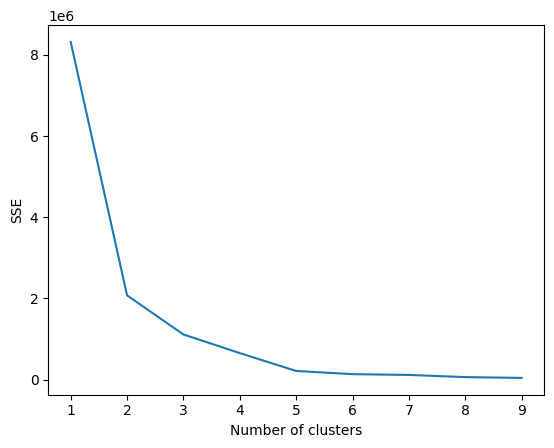

In [6]:
# Elbow criterion method

data = reduced_df.copy()
OMP_NUM_THREADS=2 #prevents data leakage on Windows

sse = {}
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(data)
    data["clusters"] = kmeans.labels_
    #print(data["clusters"])
    sse[k] = kmeans.inertia_ # Inertia: Sum of distances of samples to their closest cluster center
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of clusters")
plt.ylabel("SSE")

In [7]:
# Silhouette coefficient method

from sklearn.metrics import silhouette_score

X = reduced_df.copy()
y = TARGET_VAR

for n_cluster in range(4, 11):
    kmeans = KMeans(n_clusters=n_cluster).fit(X)
    label = kmeans.labels_
    sil_coeff = silhouette_score(X, label, metric='euclidean')
    print("For n_clusters={}, The Silhouette Coefficient is {}".format(n_cluster, sil_coeff))

# Consider: the highest coefficient typically implies the best number of clusters, but if we have 4 components: in the case where 3 clusters = 0.85
    # and 5 clusters = 0.80, the latter is more appropriate since you shouldn't have n clusters > n samples/components

For n_clusters=4, The Silhouette Coefficient is 0.8078752756118774
For n_clusters=5, The Silhouette Coefficient is 0.8973931670188904
For n_clusters=6, The Silhouette Coefficient is 0.8431578874588013
For n_clusters=7, The Silhouette Coefficient is 0.8603388667106628
For n_clusters=8, The Silhouette Coefficient is 0.8156594634056091
For n_clusters=9, The Silhouette Coefficient is 0.8542017340660095
For n_clusters=10, The Silhouette Coefficient is 0.8624159097671509


Use the suggested optimal number of clusters:

In [8]:
cluster = KMeans(
    n_clusters=5, # through different iterations 5 or 6 clusters can be considered more appropriate
    random_state=RANDOM_SEED
)

reduced_df = reduced_df.copy()
reduced_df["Cluster"] = cluster.fit_predict(reduced_df.values)
reduced_df["Cluster"] = reduced_df["Cluster"].astype(str)

# Add ID columns
reduced_df[["taxon_id", "media_id"]] = data_df.loc[X_train.index, ["taxon_id", "media_id"]].values

reduced_df.to_csv(os.path.join(DATA_DIR, "taxa-model.csv"), index=False)
reduced_df.head()

,Component 1,Component 2,Component 3,Component 4,Cluster,taxon_id,media_id
0,22.571009,5.533024,-10.793917,4.727905,3,103836,J104
1,-1.755572,28.591616,14.463669,1.759948,4,76637,J28
2,15.264657,-25.563993,11.929767,2.170387,2,589240,J104
3,45.659492,-2.858592,17.498032,-46.760525,0,1036778,1a
4,29.312813,7.219285,9.995855,-31.406555,0,"[{'NCBI tax id': 113557, 'Matching level': 'su...",J84


#### Visualise the results

In [9]:
fig = px.scatter_3d(
    data_frame=reduced_df,
    x="Component 1",
    y="Component 2",
    z="Component 3",
    color = "Component 4",
    
    hover_data=[
        "taxon_id",
        "media_id"
    ],
    template="plotly_white"
)
fig.show()

In [10]:
fig = px.scatter_3d(
    data_frame=reduced_df,
    x="Component 1",
    y="Component 2",
    z="Component 3",
    color="Cluster",
    color_discrete_sequence=px.colors.qualitative.Pastel,
    hover_data=[
        "taxon_id",
        "media_id"
    ],
    template="plotly_white"
)
fig.show()

In [11]:
# UMAP Visualization

#import numpy as np
#import umap.plot

#mapper = umap.UMAP().fit(X_train)
#umap.plot.points(mapper)
#umap.plot.connectivity(mapper, show_points=True)
#umap.plot.diagnostic(mapper, diagnostic_type='pca')

#### Create new column from clusters

In [12]:
y_train = cluster.predict(reducer.transform(X_train))
y_test = cluster.predict(reducer.transform(X_test))

y_train

array([3, 4, 2, ..., 0, 4, 4])

### Classifier

In [13]:
import sklearn
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report


model = RandomForestClassifier(
    n_estimators=100,
    n_jobs=-1,
    random_state=RANDOM_SEED
)
model.fit(X_train, y_train)

RandomForestClassifier(n_jobs=-1, random_state=666)

### Performance

#### Metrics

In [14]:
y_pred = model.predict(X_test)

report = classification_report(
    y_true=y_test,
    y_pred=y_pred,
    zero_division="warn"
)

print(report)

              precision    recall  f1-score   support

           0       0.94      0.98      0.96       531
           1       0.99      0.96      0.98       367
           2       0.99      0.95      0.97       112
           3       0.98      0.94      0.96       337
           4       0.85      0.90      0.87        97

    accuracy                           0.96      1444
   macro avg       0.95      0.95      0.95      1444
weighted avg       0.96      0.96      0.96      1444



In [15]:
from sklearn import metrics

# TODO: get PR-REC AUC score
# TODO: plot both ROC and PR-REC curves
roc_score = metrics.roc_auc_score(
    y_true=y_test,
    y_score=model.predict_proba(X_test),
    average="weighted",
    multi_class="ovo"
)

print("ROC AUC score:", roc_score)

ROC AUC score: 0.9713153506681094


#### Feature Importances

In [16]:
import xgboost
import shap

# train an XGBoost model
model2 = xgboost.XGBRegressor().fit(X_train, y_train)

# explain the model's predictions using SHAP
# (same syntax works for LightGBM, CatBoost, scikit-learn, transformers, Spark, etc.)
explainer = shap.Explainer(model2)
shap_values = explainer(X_train)

shap.plots.initjs()

In [18]:
# visualize all the training set predictions
#shap.plots.force(shap_values[:1000])

In [20]:
# summarize the effects of all the features
#shap.plots.beeswarm(shap_values)